# Plotting T & S properties

Producing plots of T and S of the CANARI-LE historic ensemble, modelled after fig 3 in Timmermans & Marshall (2020)

In [1]:
import coast
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import gsw_xarray as gsw

/home/users/eboland/.conda/envs/canari/lib/python3.10/site-packages/pydap/lib.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/home/users/eboland/.conda/envs/canari/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/home/users/eboland/.conda/envs/canari/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap.responses')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages

In [2]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

r_earth=6371e3

def add_density(ds):
    ds=ds.assign_coords({'p':gsw.p_from_z(-ds.deptht,ds.nav_lat)})
    ds['SA']=gsw.SA_from_SP(ds['vosaline'],ds.p,ds.nav_lon,ds.nav_lat)
    ds['CT']=gsw.CT_from_pt(ds['SA'],ds['votemper'])
    ds['rho']=gsw.rho(ds.SA,ds.CT,ds.p)
    return ds

In [65]:
data_path = "/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/OCN/yearly"
temp_Tgrid = f"{data_path}/cv575o_1_mon__grid_T_votemper.nc"
sal_Tgrid = f"{data_path}/cv575o_1_mon__grid_T_vosaline.nc"
nemo_dom = "/gws/nopw/j04/canari/users/dlrhodso/mesh_mask.nc"

config_grid={}
config_dir="../../tutorials/config"
for grid in ['t','f','u','v']:
    config_grid[grid]=f'{config_dir}/example_nemo_grid_{grid}.json'

In [66]:
Tdata=[]
for year in range(1985,2015):
    temp_Tgrid = f"{data_path}/{year}/cv575o_1_mon__grid_T_votemper.nc"
    sal_Tgrid = f"{data_path}/{year}/cv575o_1_mon__grid_T_vosaline.nc"
    Tdata.append(xr.open_mfdataset([temp_Tgrid,sal_Tgrid]))
Tdata=xr.concat(Tdata,'time_counter')

In [67]:
Tdata

<xarray.Dataset> Size: 396GB
Dimensions:              (time_counter: 360, axis_nbounds: 2, deptht: 75,
                          y: 1207, x: 1442, nvertex: 4)
Coordinates:
  * time_counter         (time_counter) object 3kB 1985-01-16 00:00:00 ... 20...
  * deptht               (deptht) float32 300B 0.5058 1.556 ... 5.902e+03
  * y                    (y) float64 10kB 0.0 1.0 2.0 ... 1.205e+03 1.206e+03
  * x                    (x) float64 12kB 0.0 1.0 2.0 ... 1.44e+03 1.441e+03
    nav_lat              (y, x) float32 7MB -89.5 -89.5 -89.5 ... 50.0 50.0
    nav_lon              (y, x) float32 7MB 72.75 73.0 73.25 ... 73.01 73.0 73.0
Dimensions without coordinates: axis_nbounds, nvertex
Data variables:
    time_counter_bounds  (time_counter, axis_nbounds) object 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    deptht_bounds        (time_counter, deptht, axis_nbounds) float32 216kB dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    bounds_nav_lat       (time_counter, y, x, nvertex) float32 10GB dask.array<chunksize=(12, 604, 721, 2), meta=np.ndarray>
    bounds_nav_lon       (time_counter, y, x, nvertex) float32 10GB dask.array<chunksize=(12, 604, 721, 2), meta=np.ndarray>
    vosaline             (time_counter, deptht, y, x) float32 188GB dask.array<chunksize=(1, 19, 302, 361), meta=np.ndarray>
    votemper             (time_counter, deptht, y, x) float32 188GB dask.array<chunksize=(1, 19, 302, 361), meta=np.ndarray>
Attributes: (12/35)
    Conventions:            CF-1.10
    license:                
    institution:            NCAS
    realization_index:      1
    variant_id:             r1i1p2f1
    source_type:            AOGCM
    ...                     ...
    grid:                   Native eORCA025 tripolar primarily 1/4 deg grid; ...
    source:                 HadGEM3-GC31-MM (2016):\n=aerosol: UKCA-GLOMAP-mo...
    parent_source_id:       CMIP6.CMIP.MOHC.HadGEM3-GC31-MM.historical.r1i1p1f3
    realm:                  ocean
    initialization_index:   1
    external_variables:     areacello

In [69]:
Tdata=add_density(Tdata.mean('time_counter'))

In [70]:
nemo_t = coast.Gridded(fn_data=Tdata, fn_domain=nemo_dom, config=config_grid['t'])

/home/users/eboland/.conda/envs/canari/lib/python3.10/site-packages/coast/data/gridded.py:236: UserWarning: The model domain loaded, '/gws/nopw/j04/canari/users/dlrhodso/mesh_mask.nc', does not contain the bathy_metry' variable. This will result in the NEMO.dataset.bathymetry variable being set to zero, which may result in unexpected behaviour from routines that require this variable.


In [71]:
transects=[[(70,-170),(75, -140)],[(75, -140), (90,-140)],[(90, 40), (81,40)]]

all_data=[]

r0=0
for transect in transects:
    tran_t = coast.TransectT(nemo_t,  transect[0], transect[1])
    if transect[0][0]>transect[1][0]:
        tran_t.data=tran_t.data.sortby('latitude',ascending=False)
    dy=tran_t.data.latitude.diff('r_dim')*np.pi/180*r_earth
    dx=tran_t.data.longitude.diff('r_dim')*np.pi/180*r_earth*np.cos((tran_t.data.latitude[1:]*0.5+tran_t.data.latitude[:-1]*0.5)*np.pi/180)
    dr2=dx**2+dy**2
    dr=dr2**0.5
    rr=dr.cumsum()+r0
    tran_t.data=tran_t.data.assign_coords({'distance':(['r_dim',],[r0]+list(rr.data))})
    r0=rr[-1].data
    
    #print(tran_t.data.latitude.max())
    all_data.append(tran_t.data)

all_data=xr.concat(all_data,'r_dim')
all_data

<xarray.Dataset> Size: 2MB
Dimensions:         (r_dim: 409, z_dim: 75, axis_nbounds: 2, nvertex: 4)
Coordinates:
    y               (r_dim) float64 3kB 1.05e+03 1.051e+03 ... 1.161e+03
    x               (r_dim) float64 3kB 446.0 446.0 ... 1.129e+03 1.129e+03
    longitude       (r_dim) float32 2kB -170.0 -169.9 -169.6 ... 40.69 40.05
    latitude        (r_dim) float32 2kB 70.06 70.18 70.15 ... 81.13 81.03 80.97
    depth_0         (z_dim, r_dim) float64 245kB 0.5 0.5 ... 5.871e+03 5.882e+03
    distance        (r_dim) float64 3kB 0.0 1.462e+04 ... 4.989e+06 5.002e+06
Dimensions without coordinates: r_dim, z_dim, axis_nbounds, nvertex
Data variables: (12/15)
    deptht_bounds   (r_dim, z_dim, axis_nbounds) float32 245kB dask.array<chunksize=(120, 75, 2), meta=np.ndarray>
    bounds_nav_lat  (r_dim, nvertex) float32 7kB dask.array<chunksize=(120, 2), meta=np.ndarray>
    bounds_nav_lon  (r_dim, nvertex) float32 7kB dask.array<chunksize=(120, 2), meta=np.ndarray>
    salinity        (z_dim, r_dim) float32 123kB dask.array<chunksize=(19, 120), meta=np.ndarray>
    temperature     (z_dim, r_dim) float32 123kB dask.array<chunksize=(19, 120), meta=np.ndarray>
    p               (z_dim, r_dim) float64 245kB 0.5109 0.5109 ... 6.049e+03
    ...              ...
    bathymetry      (r_dim) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    e1              (r_dim) float64 3kB 1.337e+04 1.335e+04 ... 1.259e+04
    e2              (r_dim) float64 3kB 1.463e+04 1.461e+04 ... 1.325e+04
    e3_0            (z_dim, r_dim) float64 245kB 1.023 1.023 ... 204.2 204.2
    mask            (z_dim, r_dim) int8 31kB 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    bottom_level    (r_dim) int16 818B 15 15 15 14 15 16 ... 38 39 39 39 39 37

Text(0.5, 1.0, '1985-2014 mean')

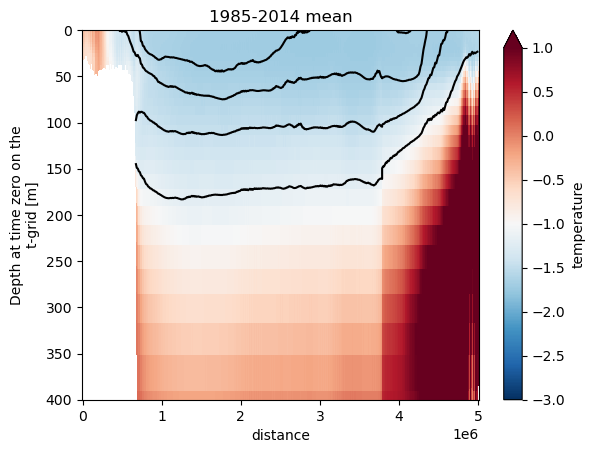

In [73]:
# It is simple to plot a scalar such as temperature along the transect:
temp_mean = all_data.temperature
temp_mean.plot.pcolormesh(x='distance',y="depth_0", yincrease=False,vmin=-3,vmax=1,cmap='RdBu_r')
(rho_mean-1000).plot.contour(x='distance',y="depth_0", yincrease=False,levels=[23.4,24,25,25.7,26.5,27.4],colors='k')
plt.ylim([400,0])
plt.title('1985-2014 mean')

In [ ]:
# It is simple to plot a scalar such as temperature along the transect:
temp_mean = all_data.salinity
temp_mean.plot.pcolormesh(x='distance',y="depth_0", yincrease=False,vmin=32,vmax=36)
(rho_mean-1000).plot.contour(x='distance',y="depth_0", yincrease=False,levels=[23.4,24,25,25.7,26.5,27.4],colors='k')
plt.ylim([400,0])

In [ ]:
#tran_t = coast.TransectT(nemo_t, (90, 40), (85,40))
#tran_t = coast.TransectT(nemo_t, (75, -180), (90,-180))

import cartopy.crs as ccrs
proj=ccrs.NorthPolarStereo()
ax=plt.subplot(projection=proj)
Tdata.votemper.isel(deptht=0).plot(x='nav_lon',y='nav_lat',ax=ax,transform= ccrs.PlateCarree(),vmin=-8,vmax=8,cmap='RdBu_r')
ax.scatter(all_data.longitude,all_data.latitude,transform= ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180,180,65,90],ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
plt.suptitle('1984-2014 Mean SST')

In [58]:
Tdata_arctic=Tdata.where(Tdata.nav_lat.load()>70,drop=True)
Tdata_arctic

<xarray.Dataset> Size: 4GB
Dimensions:              (time_counter: 12, axis_nbounds: 2, y: 163, x: 776,
                          deptht: 75, nvertex: 4)
Coordinates:
  * time_counter         (time_counter) object 96B 2010-01-16 00:00:00 ... 20...
  * deptht               (deptht) float32 300B 0.5058 1.556 ... 5.902e+03
  * y                    (y) float64 1kB 1.044e+03 1.045e+03 ... 1.206e+03
  * x                    (x) float64 6kB 203.0 204.0 ... 1.238e+03 1.239e+03
    nav_lat              (y, x) float32 506kB 61.66 61.74 61.81 ... 70.16 70.05
    nav_lon              (y, x) float32 506kB 112.3 112.5 112.7 ... 73.28 73.27
    p                    (deptht, y, x) float64 76MB dask.array<chunksize=(75, 163, 776), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, nvertex
Data variables:
    time_counter_bounds  (time_counter, axis_nbounds, y, x) object 24MB dask.array<chunksize=(1, 2, 163, 776), meta=np.ndarray>
    deptht_bounds        (deptht, axis_nbounds, y, x) float32 76MB dask.array<chunksize=(75, 2, 163, 776), meta=np.ndarray>
    bounds_nav_lat       (y, x, nvertex) float32 2MB dask.array<chunksize=(163, 388, 2), meta=np.ndarray>
    bounds_nav_lon       (y, x, nvertex) float32 2MB dask.array<chunksize=(163, 388, 2), meta=np.ndarray>
    vosaline             (time_counter, deptht, y, x) float32 455MB dask.array<chunksize=(1, 19, 163, 158), meta=np.ndarray>
    votemper             (time_counter, deptht, y, x) float32 455MB dask.array<chunksize=(1, 19, 163, 158), meta=np.ndarray>
    SA                   (time_counter, deptht, y, x) float64 911MB dask.array<chunksize=(1, 19, 163, 158), meta=np.ndarray>
    CT                   (time_counter, deptht, y, x) float64 911MB dask.array<chunksize=(1, 19, 163, 158), meta=np.ndarray>
    rho                  (time_counter, deptht, y, x) float64 911MB dask.array<chunksize=(1, 19, 163, 158), meta=np.ndarray>
Attributes: (12/35)
    Conventions:            CF-1.10
    license:                
    institution:            NCAS
    realization_index:      1
    variant_id:             r1i1p2f1
    source_type:            AOGCM
    ...                     ...
    grid:                   Native eORCA025 tripolar primarily 1/4 deg grid; ...
    source:                 HadGEM3-GC31-MM (2016):\n=aerosol: UKCA-GLOMAP-mo...
    parent_source_id:       CMIP6.CMIP.MOHC.HadGEM3-GC31-MM.historical.r1i1p1f3
    realm:                  ocean
    initialization_index:   1
    external_variables:     areacello

Text(0.5, 0.98, 'March 2010')

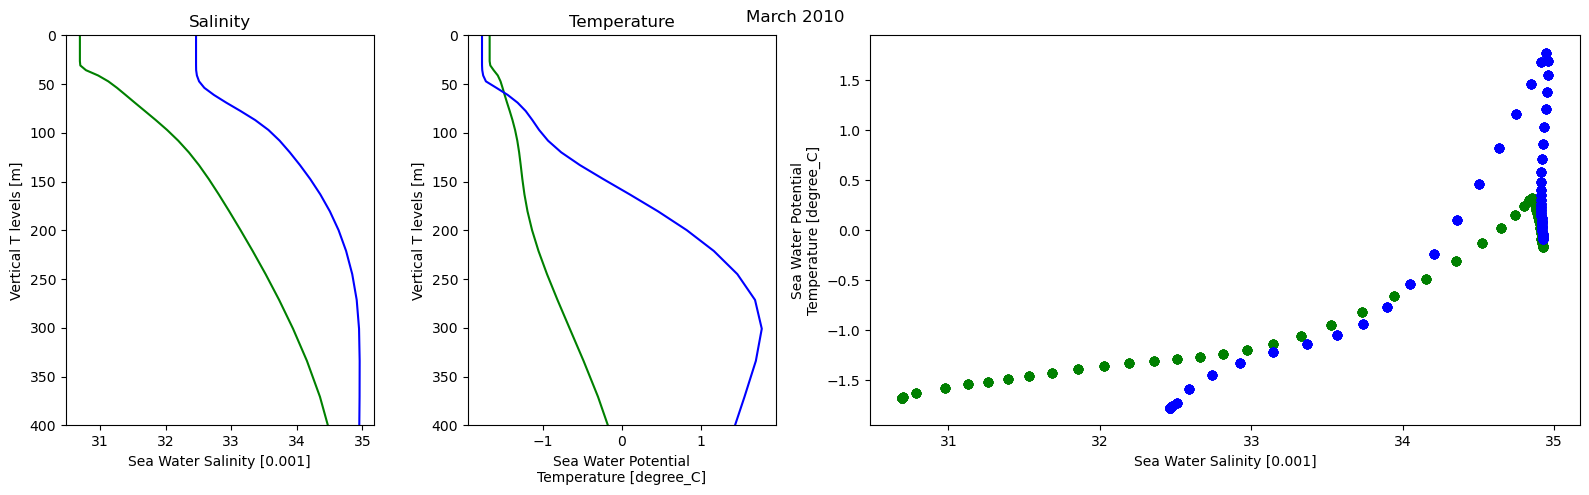

In [59]:
plot_locs=[[75,-140],[85,40]]
colors=['g','b']
#[fig,axes]=plt.subplots(1,4)
fig = plt.figure(figsize=[16,5])

gs = fig.add_gridspec(1,4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2:])

for iloc,loc in enumerate(plot_locs):
    [yy,xx]=nemo_t.find_j_i(lat=loc[0],lon=loc[1])
    Tplot=Tdata.isel(x=xx,y=yy).isel(time_counter=2)
    Tplot.vosaline.plot(y='deptht',yincrease=False,color=colors[iloc],ax=ax1)
    ax1.set_ylim([400,0])
    ax1.set_title('Salinity')
    Tplot.votemper.plot(y='deptht',yincrease=False,color=colors[iloc],ax=ax2)
    ax2.set_ylim([400,0])
    ax2.set_title('Temperature')
    Tplot.plot.scatter(x='vosaline',y='votemper',color=colors[iloc],ax=ax3)
    ax3.set_title('')
plt.tight_layout()
plt.suptitle('March 2010')